# Capstone

For our capstone we constructed a machine learning model that could predict if there is a tumor using brain MRI scans as our inputs. The dataset we will be using can be found on Kaggle. We had an original data size of 253 MRI scans. We did some data augmentation and were able increase our data size to 1012 images. For our model we used a convolutional neural network. our model had an average of about 90% accuracy that is still being tested along with multiple other aspects of our dataset. 

## Loading Data

In [1]:
# creates dir for kaggle 
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: cannot access 'kaggle.json': No such file or directory


In [2]:
# Download Data
!kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection
!ls

brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
brain-mri-images-for-brain-tumor-detection.zip	no	     yes
brain_tumor_dataset				sample_data


In [3]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


---

## Exploratory Data Analysis

In [4]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import random
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import ImageOps, Image
from matplotlib import cm

In [5]:
all_data_dir = pathlib.Path('/content/brain_tumor_dataset')
yes_dir = pathlib.Path('/content/yes')
no_dir = pathlib.Path('/content/no')

In [6]:
dataCount = len(list(all_data_dir.glob('*')))
print(dataCount)
yesCount = len(list(yes_dir.glob('*')))
print(yesCount)
noCount = len(list(no_dir.glob('*')))
print(noCount)

2
155
98


In [7]:
image_count = len(list(all_data_dir.glob('*/*')))
print(image_count)

1012


In [8]:
target_height = 300
target_width = 350

In [9]:
image_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    target_size=(target_height, target_width),
    directory=all_data_dir,
    batch_size=128,
    image_data_generator=None)

Found 1012 images belonging to 2 classes.


In [10]:
def rescale(img):
  img = np.array(img)
  low = np.percentile(img, 1.5)
  high = np.percentile(img, 99.5)
  # print(low, high)
  img[img<low] = 0.
  img[img>high] = high
  img = img/high
  return img

In [11]:
def normalize(img):
  for i in range(3):
    img[:,:,i][img[:,:,i]>0.5] = (img[:,:,i][img[:,:,i]>0.5] - np.mean(img[:,:,i][img[:,:,i]>0.5]))/np.std(img[:,:,i][img[:,:,i]>0.5])
  return img

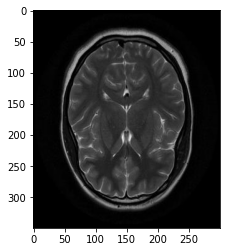

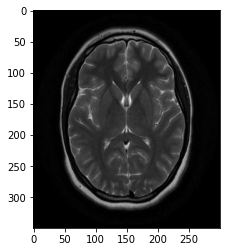

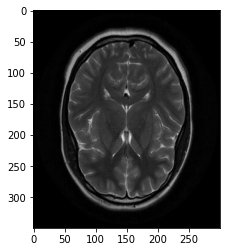

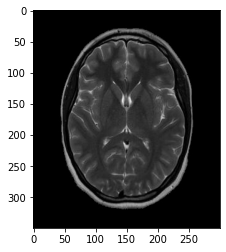

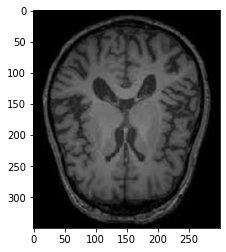

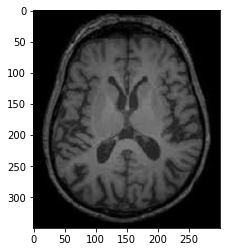

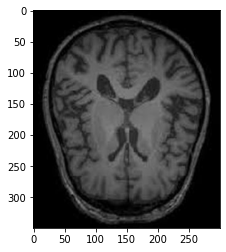

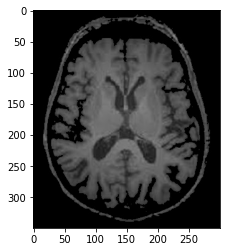

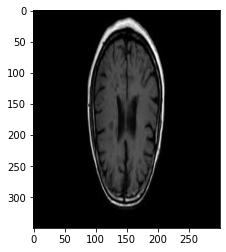

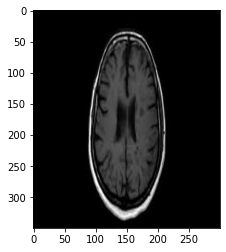

In [12]:
arr = image_iterator.filepaths

j=0

for i in arr: 
  image = i
  img = PIL.Image.open(image)
  img = img.convert('RGB')
  img = img.resize((target_height, target_width), Image.ANTIALIAS)

  flip = ImageOps.flip(img)
  mirror = ImageOps.mirror(img)
  rotate = img.rotate(180)
  # img = rescale(img)
  # img = normalize(img)

  if j < 10:
    plt.figure()
    plt.imshow(img)
    # plt.imshow((img==0)*1., alpha=0.5)
  #   plt.figure()
  #   plt.imshow(flip)
  #   plt.figure()
  #   plt.imshow(mirror)
  #   plt.figure()
  #   plt.imshow(rotate)
    j += 1
  
  new = i.strip('.jpeg')
  name = new + '-flipped.jpeg'
  name2 = new + '-mirror.jpeg'
  name3 = new + '-rotate.jpeg'
  flip.save(name)
  mirror.save(name2)
  rotate.save(name3)
  # overwrites resized image into dir
  # img = Image.fromarray(np.uint8(cm.gist_earth(img)*255))
  img.save(i)


In [13]:
import cv2
j = 0

for i in arr:
  image = cv2.imread(i)
  
  # Grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  mask = np.zeros_like(gray)
  ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  # contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  # cv2.drawContours(gray,contours,-1,(0,255,0),2)
  # print(contours)
  # raise
  # plt.imshow(gray)
  # plt.plot(contours[0][:,0,0],contours[0][:,0,1], c="r")
  cv2.fillPoly(mask, pts=contours, color=(255,255,255))

  gray[mask==0] = 0 

  # this is your data
  img = np.expand_dims(gray, axis=2)
  cv2.imwrite(i, img)
  # plt.imshow(gray)
  # print(gray)
  # plt.imshow(mask, alpha=.5)
  # plt.figure()


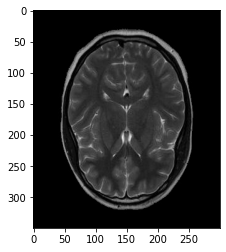

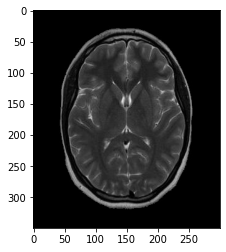

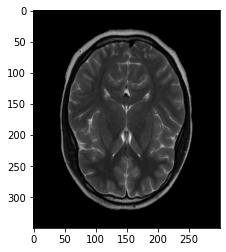

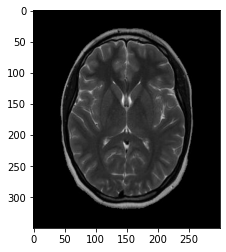

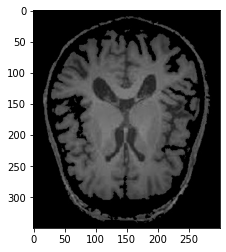

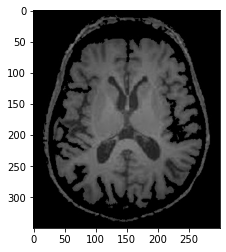

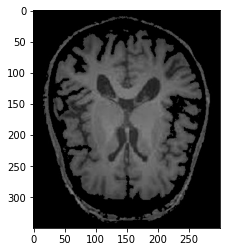

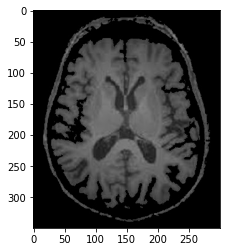

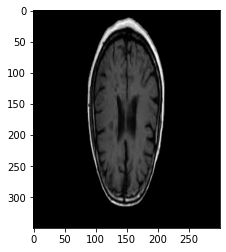

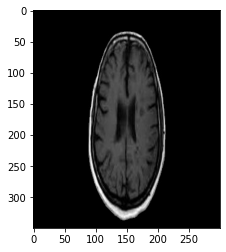

<Figure size 432x288 with 0 Axes>

In [14]:
j = 0
for i in arr:
  if j < 10:
    image = cv2.imread(i)
    plt.imshow(image)
    plt.figure()
  j += 1

In [15]:
image_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    target_size=(target_height, target_width),
    directory=all_data_dir,
    batch_size=128,
    image_data_generator=None)

Found 3289 images belonging to 2 classes.


## Splitting Data

In [16]:
split_size = .2
batch_size = np.round(image_iterator.n * split_size)
print(batch_size)

658.0


In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  all_data_dir,
  #labels=None,
  validation_split=split_size,
  subset="training",
  seed=123,
  image_size=(target_height, target_width),
  batch_size=batch_size)

Found 3289 files belonging to 2 classes.
Using 2632 files for training.


In [18]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_labels.size

2632

In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  all_data_dir,
  #labels=None,
  validation_split=split_size,
  subset="validation",
  seed=123,
  image_size=(target_height, target_width),
  batch_size=batch_size)

Found 3289 files belonging to 2 classes.
Using 657 files for validation.


In [20]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_labels.size

657

In [21]:
val_labels

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

In [22]:
class_names = train_ds.class_names
print('train class names =', class_names)
class_names = val_ds.class_names
print('val class names =', class_names)

train class names = ['no', 'yes']
val class names = ['no', 'yes']


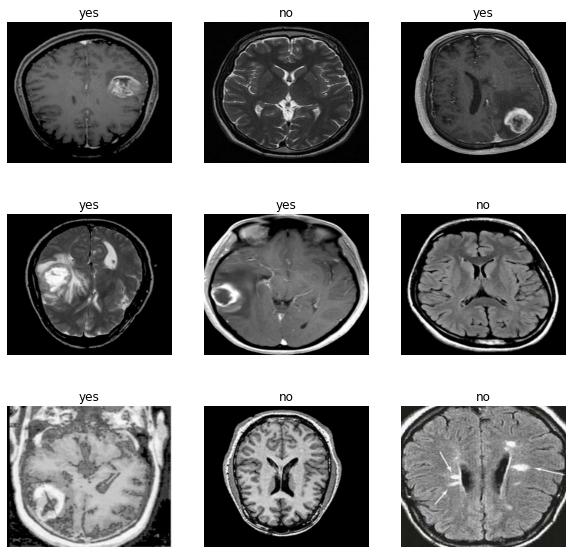

In [23]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy()
  plt.imshow(img.astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Build And Train Model

In [24]:
num_classes = 1

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(target_height, target_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 350, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 350, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 175, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 175, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 87, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 43, 64)        0

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience= 15)

In [27]:
epochs=50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=early_stop
)

Epoch 1/50


ResourceExhaustedError: ignored

## Checking Model Accuracy

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(val_ds)

## Predictions

In [ ]:
image_batch, label_batch = next(iter(val_ds))

num = random.randint(0, len(image_batch)-1)
plt.imshow(image_batch[num].numpy().astype('uint8'))
plt.show()
predictions = model.predict(image_batch)
rounded_predictions = abs(np.round(predictions + .25))
# print(predictions)
# print(rounded_predictions)
#rounded_labels = np.argmax(label_batch)
# print(label_batch)

print('Prediction:', rounded_predictions[num])
print('Actual:', label_batch[num])

print('\nclassification report:')
print(classification_report(label_batch, rounded_predictions))

print('confusion matrix:')
cm = confusion_matrix(label_batch, rounded_predictions)
sns.heatmap(cm, xticklabels=[0, 1], yticklabels=[0,1], annot=True)